In [1]:
import os
import csv
import pandas as pd
import numpy as np

In [2]:
dataset_names=[]
X_trains=[]
y_trains=[]
X_tests=[]

path = "C:/Users/User/Desktop/SeniorYearFirstSem/DataScience/Competition1_code/Competition_data"
for folder_name in os.listdir(path):
    print(folder_name)
    dataset_names.append(folder_name)
    X_trains.append(pd.read_csv(f"{path}/{folder_name}/X_train.csv", header=0))
    y_trains.append(pd.read_csv(f"{path}/{folder_name}/y_train.csv", header=0))
    X_tests.append(pd.read_csv(f"{path}/{folder_name}/X_test.csv", header=0))

Dataset_1
Dataset_10
Dataset_11
Dataset_12
Dataset_13
Dataset_14
Dataset_15
Dataset_16
Dataset_17
Dataset_18
Dataset_19
Dataset_2
Dataset_20
Dataset_21
Dataset_22
Dataset_23
Dataset_24
Dataset_25
Dataset_26
Dataset_27
Dataset_28
Dataset_29
Dataset_3
Dataset_30
Dataset_31
Dataset_32
Dataset_33
Dataset_34
Dataset_35
Dataset_36
Dataset_37
Dataset_38
Dataset_39
Dataset_4
Dataset_40
Dataset_41
Dataset_42
Dataset_43
Dataset_44
Dataset_45
Dataset_46
Dataset_47
Dataset_48
Dataset_49
Dataset_5
Dataset_6
Dataset_7
Dataset_8
Dataset_9


In [3]:
## Train & Test & Split & Build Model
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [4]:
def remove_outliers(df, columns=None, lower_percentile=0.01, upper_percentile=0.99):
    """
    根据分位数去除异常值。
    """
    if columns is None:
        columns = df.select_dtypes(include=['float64', 'int64']).columns
    for col in columns:
        lower_bound = df[col].quantile(lower_percentile)
        upper_bound = df[col].quantile(upper_percentile)
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

from scipy.stats import boxcox
def adjust_skewness(df, skew_threshold=0.75):
    """
    调整偏态较高的数值型特征。
    """
    numeric_cols = df.select_dtypes(include=['float64', 'int64'])
    for col in numeric_cols.columns:
        skewness = df[col].skew()
        if abs(skewness) > skew_threshold:  # 偏态较大
            if (df[col] > 0).all():  # Box-Cox 需要正值
                df[col], _ = boxcox(df[col] + 1e-6)
            else:  # 如果包含非正数，用 log1p
                df[col] = np.log1p(df[col] - df[col].min() + 1e-6)
    return df

from sklearn.preprocessing import LabelEncoder
def encode_categorical_features(df, categorical_columns=None):
    """
    使用 LabelEncoder 对类别型特征编码。
    """
    if categorical_columns is None:
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    encoder_dict = {}
    for col in categorical_columns:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col].astype(str))
        encoder_dict[col] = encoder
    return df, encoder_dict

from sklearn.feature_selection import VarianceThreshold

def remove_low_variance_features(df, threshold=0.01):
    """
    移除方差低于指定阈值的特征。
    """
    numeric_data = df.select_dtypes(include=['float64', 'int64'])
    selector = VarianceThreshold(threshold=threshold)
    numeric_data_transformed = selector.fit_transform(numeric_data)
    retained_columns = numeric_data.columns[selector.get_support()]
    return df[retained_columns]

from imblearn.over_sampling import SMOTE

def balance_classes(X, y):
    """
    使用 SMOTE 方法平衡类别分布。
    """
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

def select_important_features(model, X, importance_threshold=0.01):
    """
    基于特征重要性选择重要特征。
    """
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    selected_features = feature_importances[feature_importances > importance_threshold].index
    return X[selected_features]


In [5]:
def preprocess_pipeline(X, y=None):
    # Step 1: 去除异常值
    X = remove_outliers(X)

    # Step 2: 调整偏态
    X = adjust_skewness(X)

    # Step 3: 删除低方差特征
    X = remove_low_variance_features(X)

    # Step 4: 编码类别型特征
    X, encoder_dict = encode_categorical_features(X)

    # Step 5: 平衡类别（需要标签）
    if y is not None:
        X, y = balance_classes(X, y)

    return X, y, encoder_dict


In [6]:
def align_features(X_train, X_test):
    """
    对齐训练集和测试集的特征。
    """
    missing_cols = set(X_train.columns) - set(X_test.columns)
    for col in missing_cols:
        X_test[col] = 0
    X_test = X_test[X_train.columns]  # 确保列顺序一致
    return X_test

average_auc = 0
y_predicts = []
auc_results = []  # 保存每个数据集的 AUC 结果

for i in range(len(dataset_names)):

    print(f"Processing Dataset: {dataset_names[i]}")

    # 獲取當前數據集的特徵和標籤
    X_sample = X_trains[i]
    y_sample = y_trains[i].values.ravel()
    X_test = X_tests[i]

    # 確保數據格式一致
    if not isinstance(X_sample, pd.DataFrame):
        X_sample = pd.DataFrame(X_sample)
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test)

    # 定义模型
    model = lgb.LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=31,
        max_depth=6,
        learning_rate=0.05,
        n_estimators=500,
        objective='binary',
        random_state=42,
        is_unbalance=True
    )

    # Step 1: 测试未经过预处理的性能
    X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, train_size=0.6, random_state=123)
    eval_set = [(X_train, y_train), (X_val, y_val)]
    model.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        eval_metric='auc',
        callbacks=[lgb.early_stopping(50)]
    )

    y_val_proba_raw = model.predict_proba(X_val)[:, 1]
    auc_raw = roc_auc_score(y_val, y_val_proba_raw)

    print(f"Dataset {dataset_names[i]} Raw Validation AUC: {auc_raw:.4f}")

    # Step 2: 直接进行预处理
    X_sample_preprocessed, y_sample_preprocessed, encoder = preprocess_pipeline(X_sample, y_sample)
    X_test_processed, _, _ = preprocess_pipeline(X_test)

    # 对齐训练和测试的特征
    X_test_processed = align_features(X_sample_preprocessed, X_test_processed)

    # 测试经过预处理的数据
    X_train_preprocessed, X_val_preprocessed, y_train_preprocessed, y_val_preprocessed = train_test_split(
        X_sample_preprocessed, y_sample_preprocessed, train_size=0.6, random_state=123
    )

    model.fit(
        X_train_preprocessed,
        y_train_preprocessed,
        eval_set=[(X_val_preprocessed, y_val_preprocessed)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(50)]
    )

    y_val_proba_preprocessed = model.predict_proba(X_val_preprocessed)[:, 1]
    auc_preprocessed = roc_auc_score(y_val_preprocessed, y_val_proba_preprocessed)

    print(f"Dataset {dataset_names[i]} Preprocessed Validation AUC: {auc_preprocessed:.4f}")


    X_sample, y_sample, X_test_processed = X_sample_preprocessed, y_sample_preprocessed, X_test_processed


    # 最终模型训练
    model.fit(X_sample, y_sample)

    # 修正测试集特征
    X_test_processed = align_features(X_sample, X_test_processed)

    y_test_proba = model.predict_proba(X_test_processed)[:, 1]
    y_predicts.append(pd.DataFrame(y_test_proba, columns=['y_predict_proba']))

    # 保存当前数据集的 AUC
    auc_results.append({
        "dataset_name": dataset_names[i],
        "auc_raw": auc_raw,
        "auc_preprocessed": auc_preprocessed if 'auc_preprocessed' in locals() else None
    })

    # 保存预测结果
    output_dir = os.path.join(path, dataset_names[i])
    os.makedirs(output_dir, exist_ok=True)
    y_predicts[-1].to_csv(os.path.join(output_dir, "y_predict.csv"), index=False)

    # 更新 AUC 统计
    average_auc += max(auc_raw, auc_preprocessed) if 'auc_preprocessed' in locals() else auc_raw

# 保存 AUC 结果到 CSV 文件
auc_df = pd.DataFrame(auc_results)
auc_df.to_csv("auc_results.csv", index=False)

# 平均 AUC
average_auc /= len(dataset_names)
print(f"Average AUC = {average_auc:.4f}")


Processing Dataset: Dataset_1
[LightGBM] [Info] Number of positive: 82, number of negative: 184
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 223
[LightGBM] [Info] Number of data points in the train set: 266, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.308271 -> initscore=-0.808217
[LightGBM] [Info] Start training from score -0.808217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

C:\Users\User\AppData\Local\Temp\ipykernel_101468\988880561.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = 0


[LightGBM] [Info] Number of positive: 69, number of negative: 85
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 782
[LightGBM] [Info] Number of data points in the train set: 154, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448052 -> initscore=-0.208545
[LightGBM] [Info] Start training from score -0.208545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

C:\Users\User\AppData\Local\Temp\ipykernel_101468\988880561.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = 0


[LightGBM] [Info] Number of positive: 69, number of negative: 85
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 154, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448052 -> initscore=-0.208545
[LightGBM] [Info] Start training from score -0.208545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

C:\Users\User\AppData\Local\Temp\ipykernel_101468\988880561.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = 0


[LightGBM] [Info] Number of positive: 204, number of negative: 222
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1143
[LightGBM] [Info] Number of data points in the train set: 426, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.478873 -> initscore=-0.084557
[LightGBM] [Info] Start training from score -0.084557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

C:\Users\User\AppData\Local\Temp\ipykernel_101468\988880561.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = 0
C:\Users\User\AppData\Local\Temp\ipykernel_101468\988880561.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = 0
C:\Users\User\AppData\Local\Temp\ipykernel_101468\988880561.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

[LightGBM] [Info] Number of positive: 71, number of negative: 58
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 363
[LightGBM] [Info] Number of data points in the train set: 129, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.550388 -> initscore=0.202237
[LightGBM] [Info] Start training from score 0.202237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

C:\Users\User\AppData\Local\Temp\ipykernel_101468\988880561.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = 0


[LightGBM] [Info] Number of positive: 299, number of negative: 284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1017
[LightGBM] [Info] Number of data points in the train set: 583, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512864 -> initscore=0.051469
[LightGBM] [Info] Start training from score 0.051469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_morestats.py:1133: UserWarning: The optimal lambda is -2371.2231986372617, but the returned lambda is the constrained optimum to ensure that the maximum or the minimum of the transformed data does not overflow in float64.
  lmax = boxcox_normmax(x, method='mle', optimizer=optimizer)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1904: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_morestats.py:1133: UserWarning: The optimal lambda is -2289.2276118292157, but the returned lambda is the constrained optimum to ensure that the maximum or the minimum of the transformed data does not overflow in float64.
  lmax = boxcox_normmax(x, method='mle', optimizer=optimizer)
c:\Users\User\AppData\Local\Programs\Python\Python3

In [23]:
def align_features(X_train, X_test):
    """
    对齐训练集和测试集的特征。
    """
    missing_cols = set(X_train.columns) - set(X_test.columns)
    for col in missing_cols:
        X_test[col] = 0
    X_test = X_test[X_train.columns]  # 确保列顺序一致
    return X_test

average_auc = 0
y_predicts = []
auc_results = []  # 保存每个数据集的 AUC 结果

for i in range(len(dataset_names)):

    print(f"Processing Dataset: {dataset_names[i]}")

    # 獲取當前數據集的特徵和標籤
    X_sample = X_trains[i]
    y_sample = y_trains[i].values.ravel()
    X_test = X_tests[i]

    # 確保數據格式一致
    if not isinstance(X_sample, pd.DataFrame):
        X_sample = pd.DataFrame(X_sample)
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test)

    # 定义模型
    model = lgb.LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=31,
        max_depth=6,
        learning_rate=0.05,
        n_estimators=500,
        objective='binary',
        random_state=42,
        is_unbalance=True
    )

    # Step 1: 测试未经过预处理的性能
    X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, train_size=0.6, random_state=123)
    eval_set = [(X_train, y_train), (X_val, y_val)]
    model.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        eval_metric='auc',
        callbacks=[lgb.early_stopping(50)]
    )

    y_val_proba_raw = model.predict_proba(X_val)[:, 1]
    auc_raw = roc_auc_score(y_val, y_val_proba_raw)

    print(f"Dataset {dataset_names[i]} Raw Validation AUC: {auc_raw:.4f}")

    if auc_raw >= 1.0:
        print(f"Dataset {dataset_names[i]} reached perfect AUC without preprocessing. Skipping preprocessing.")
        X_sample_preprocessed, y_sample_preprocessed, X_test_processed = X_sample, y_sample, X_test
    else:
        # Step 2: 直接进行预处理
        X_sample_preprocessed, y_sample_preprocessed, encoder = preprocess_pipeline(X_sample, y_sample)
        X_test_processed, _, _ = preprocess_pipeline(X_test)

        # 对齐训练和测试的特征
        X_test_processed = align_features(X_sample_preprocessed, X_test_processed)

        # 测试经过预处理的数据
        X_train_preprocessed, X_val_preprocessed, y_train_preprocessed, y_val_preprocessed = train_test_split(
            X_sample_preprocessed, y_sample_preprocessed, train_size=0.6, random_state=123
        )

        model.fit(
            X_train_preprocessed,
            y_train_preprocessed,
            eval_set=[(X_val_preprocessed, y_val_preprocessed)],
            eval_metric='auc',
            callbacks=[lgb.early_stopping(50)]
        )

        y_val_proba_preprocessed = model.predict_proba(X_val_preprocessed)[:, 1]
        auc_preprocessed = roc_auc_score(y_val_preprocessed, y_val_proba_preprocessed)

        print(f"Dataset {dataset_names[i]} Preprocessed Validation AUC: {auc_preprocessed:.4f}")

        # 比较两种方式的 AUC
        if auc_preprocessed > auc_raw:
            print(f"Using preprocessed data for Dataset {dataset_names[i]}.")
            X_sample, y_sample, X_test_processed = X_sample_preprocessed, y_sample_preprocessed, X_test_processed
        else:
            print(f"Using raw data for Dataset {dataset_names[i]}.")
            X_test_processed = X_test

    # 最终模型训练
    model.fit(X_sample, y_sample)

    # 修正测试集特征
    X_test_processed = align_features(X_sample, X_test_processed)

    y_test_proba = model.predict_proba(X_test_processed)[:, 1]
    y_predicts.append(pd.DataFrame(y_test_proba, columns=['y_predict_proba']))

    # 保存当前数据集的 AUC
    auc_results.append({
        "dataset_name": dataset_names[i],
        "auc_raw": auc_raw,
        "auc_preprocessed": auc_preprocessed if 'auc_preprocessed' in locals() else None
    })

    # 保存预测结果
    output_dir = os.path.join(path, dataset_names[i])
    os.makedirs(output_dir, exist_ok=True)
    y_predicts[-1].to_csv(os.path.join(output_dir, "y_predict.csv"), index=False)

    # 更新 AUC 统计
    average_auc += max(auc_raw, auc_preprocessed) if 'auc_preprocessed' in locals() else auc_raw

# 保存 AUC 结果到 CSV 文件
auc_df = pd.DataFrame(auc_results)
auc_df.to_csv("auc_results.csv", index=False)

# 平均 AUC
average_auc /= len(dataset_names)
print(f"Average AUC = {average_auc:.4f}")



Processing Dataset: Dataset_1
[LightGBM] [Info] Number of positive: 82, number of negative: 184
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 221
[LightGBM] [Info] Number of data points in the train set: 266, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.308271 -> initscore=-0.808217
[LightGBM] [Info] Start training from score -0.808217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

C:\Users\User\AppData\Local\Temp\ipykernel_77520\3074523635.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = 0


[LightGBM] [Info] Number of positive: 69, number of negative: 85
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 154, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448052 -> initscore=-0.208545
[LightGBM] [Info] Start training from score -0.208545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1259: RuntimeWarning: overflow encountered in square
  adjusted2 = adjusted**2
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1904: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1259: RuntimeWarning: overflow encountered in square
  adjusted2 = adjusted**2
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Us

[LightGBM] [Info] Number of positive: 44, number of negative: 44
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1363
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

>>> Plot Graph

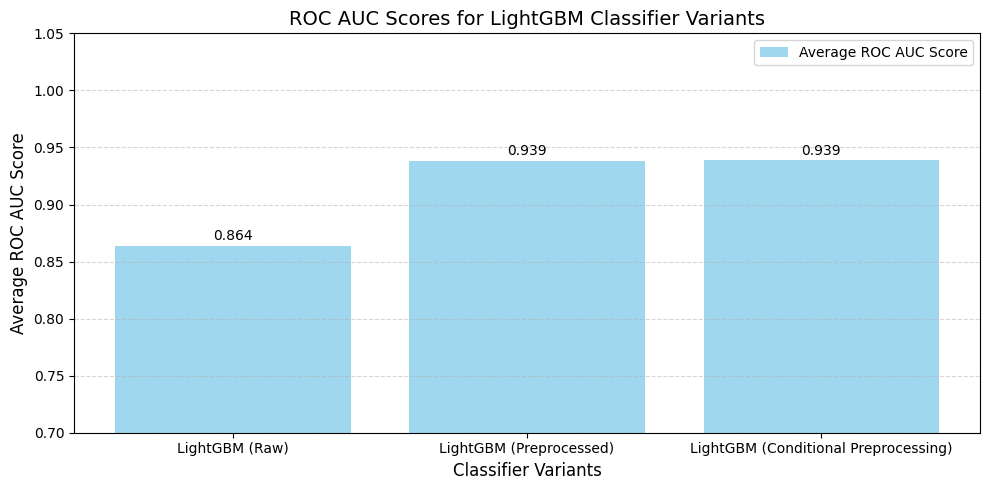

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# AUC_set values
AUC_set = [
    np.float64(0.8639),
    np.float64(0.9385),
    np.float64(0.9388),
]

classifiers = [
    "LightGBM (Raw)",
    "LightGBM (Preprocessed)",
    "LightGBM (Conditional Preprocessing)"
]

# Plotting the bar graph
plt.figure(figsize=(10, 5))
bars = plt.bar(classifiers, AUC_set, color='skyblue', alpha=0.8, label='Average ROC AUC Score')

# Annotate data points with their corresponding AUC values
for bar, value in zip(bars, AUC_set):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 0.005, f"{value:.3f}", 
             ha='center', fontsize=10)  # Display AUC values above the bars

plt.title('ROC AUC Scores for LightGBM Classifier Variants', fontsize=14)  
plt.xlabel('Classifier Variants', fontsize=12)  
plt.ylabel('Average ROC AUC Score', fontsize=12)  
plt.ylim(0.7, 1.05)  # Set Y-axis limits
plt.grid(visible=True, linestyle='--', alpha=0.5, axis='y')  # Add horizontal gridlines
plt.legend(fontsize=10, loc='upper right')  # Add legend

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()